# Optical Character Recognition System using Deep Learning

In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
import string

In [33]:
# import zipfile

# # Specify the path to the zip file and the extraction directory
# zip_path = '/content/dataset.zip'
# extract_to = '/content/'

# # Open the zip file and extract all contents
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

In [34]:
# import easyocr

# # Initialize the reader object with the languages you need
# reader = easyocr.Reader(['en'])  # English

# # Recognize text from an image
# results = reader.readtext('/content/s01-000-00-0.png')

# # Display results
# s = ""
# for bbox, text, confidence in results:
#   s += text + " "
#   print(f"Detected text: {text}, Confidence: {confidence}")
# print(s)

Here UsedSentences.txt Contains the output of the text in the Image and the name of the Image. The name of the image is used to extract the image from the directory and add it to our dataset.

In [35]:
# !pip install easyocr

X shape is :  (1774, 32, 784)
No of Images : 1774
Characters :  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.,*&!@~():`^]¢‘;|-«
No of chars : 82


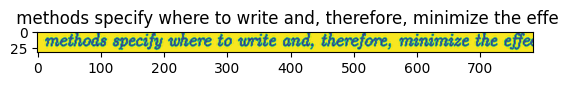

In [36]:

from PIL import Image

text_file=open(r"./dataset/UsedSentences.txt","r")

details=[]
outputs=[]
names=[]
for line in text_file:
    a=line.split('#')
    outputs.append(a[1].strip('\n'))
    details.append(a[0])

for detail in details:
    a=detail.split(' ')
    names.append(a[0])
X=[]

for name in names:
    img=Image.open('./dataset/CleanedImages/Encoder_Clean_Renamed/'+name+'.png','r')
    img = img.resize((784,32), Image.LANCZOS)
    img=np.asarray(img)
    img=img[:,:,0]
    X.append(img)

X=np.asarray(X)
plt.imshow(X[42])
plt.title(outputs[42])
print("X shape is : ", X.shape)
print("No of Images :",X.shape[0])

symbols = " "+string.ascii_lowercase + string.ascii_uppercase+"0123456789.,*&!@~():`^]¢‘;|-«"
print("Characters :",symbols)
print("No of chars :",len(symbols))

# print(os.listdir('../input/linesdata/data/sentences/s01/'))


One Hot Encoded Array. 98 is taken as the maximum number of Character in the Sentences. If the letter is present in the output then it is encoded to 1.

In [37]:
Y=np.zeros(shape=(len(outputs),98,len(symbols)))
for example_no,name in enumerate(outputs):
    for letter_no,letter in enumerate(name):
        try:
            Y[example_no][letter_no][symbols.index(letter)]=1
        except:
            print(letter,end=" ")

Just Reshaping the Shape of X in order to pass it to the convolution.

In [38]:
X=np.reshape(X,(X.shape[0],X.shape[1],X.shape[2],1))
print("Shape of X is :",X.shape)
print("Shape of Y is :",Y.shape)
print("Sample Y :",Y[0].shape)

Shape of X is : (1774, 32, 784, 1)
Shape of Y is : (1774, 98, 82)
Sample Y : (98, 82)


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=35)

In [40]:

def OCRModel():
    image = keras.layers.Input((32, 784, 1))
    conv1 = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(image)
    mp1 = keras.layers.MaxPooling2D((2, 2), padding='same')(conv1)
    conv2 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(mp1)
    mp2 = keras.layers.MaxPooling2D((2, 2), padding='same')(conv2)
    conv3 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(mp2)
    mp3 = keras.layers.MaxPooling2D((2, 2), padding='same')(conv3)
    conv4 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(mp3)
    mp4 = keras.layers.MaxPooling2D((2, 1), padding='same')(conv4)
    conv5 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(mp4)
    mp5 = keras.layers.MaxPooling2D((2, 1), padding='same')(conv5)
    conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(mp5)

    bn = keras.layers.BatchNormalization()(conv6)
    sq = keras.layers.Lambda(lambda x: tf.squeeze(x, axis=1) if x.shape[1] == 1 else x)(bn)

    rn1 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(sq)
    rn2 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(rn1)

    # Adjust final layer for correct shape
    mapping = keras.layers.TimeDistributed(keras.layers.Dense(len(symbols), activation='softmax'))(rn2)

    model = keras.Model(image, mapping)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [55]:
# from tensorflow.keras.utils import plot_model
OCR = OCRModel()
OCR.summary()

# plot_model(OCR, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 784, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 784, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 392, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 16, 392, 32)         │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 196, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 196, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 4, 98, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 4, 98, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 2, 98, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 2, 98, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 1, 98, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 1, 98, 256)          │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 98, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_2 (Lambda)                    │ (None, 98, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 98, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 98, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 98, 82)              │          42,066 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,651,026 (13.93 MB)

 Trainable params: 3,650,514 (13.93 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# training the model
OCR.fit(X_train,Y_train,epochs=50)

In [42]:
# Predicting the text for whole dataset
print("X shape is : ", X_test.shape)
# print("No of Images :",X.shape[0])
xx=OCR.predict(X_test)
print("shape of predictions : ", xx.shape)

X shape is :  (355, 32, 784, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step
shape of predictions :  (355, 98, 82)


Decoding the Output of the Model and Comparing it.....

In [43]:
print(len(outputs))
print(outputs[0])

1774
 There exist several methods to design forms with fields to


In [48]:
# get the accuracy
# Function to decode one-hot encoded sequences to strings
def decode_sequence(one_hot_seq, symbols):
    decoded = ""
    for one_hot_vector in one_hot_seq:
        decoded += symbols[np.argmax(one_hot_vector)]
    return decoded.strip()

In [49]:
# Calculate accuracy on test set
correct_sequences = 0
total_sequences = Y_test.shape[0]
correct_chars = 0
total_chars = 0

for i in range(total_sequences):
    predicted_sequence = decode_sequence(xx[i], symbols)
    actual_sequence = decode_sequence(Y_test[i], symbols)

    # Count correctly predicted characters
    for j in range(len(actual_sequence)):
        if j < len(predicted_sequence) and predicted_sequence[j] == actual_sequence[j]:
            correct_chars += 1
    total_chars += len(actual_sequence)

    # Check if the entire sequence is correct
    if predicted_sequence[:len(actual_sequence)] == actual_sequence:
        correct_sequences += 1

# Calculate character-level and sequence-level accuracy
char_accuracy = correct_chars / total_chars
sequence_accuracy = correct_sequences / total_sequences

print(f"Character-level accuracy: {char_accuracy*100:.4f}")
print(f"Sequence-level accuracy: {sequence_accuracy*100:.4f}")


Character-level accuracy: 99.3146
Sequence-level accuracy: 90.4225


Predicted Sequence: operations in order to eliminate small object
Actual Sequence: operations in order to eliminate small object


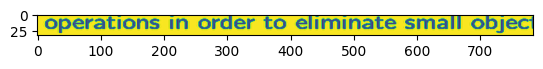

In [52]:
# testing the sample output
total_sequences = Y_test.shape[0]
# get random index in between 0 and total_sequences
i = np.random.randint(0, total_sequences)
predicted_sequence = decode_sequence(xx[i], symbols)
actual_sequence = decode_sequence(Y_test[i], symbols)
print("Predicted Sequence:", predicted_sequence[:len(actual_sequence)])
print("Actual Sequence:", actual_sequence)
plt.imshow(X_test[i][:,:,0])


If you like the Code feel free to fork the Notebook and don't forget to Upvote it. Cheers....